# Data Collection and Preprocessing

In [2]:
import pandas as pd

file_path = 'CloudWatch_Traffic_Web_Attack.csv'
df = pd.read_csv(file_path)

df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

missing_values = df.isnull().sum()
print(df.info())
print(missing_values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source.meta          2

# Feature Extraction

In [3]:
df['packet_size'] = df['bytes_in'] + df['bytes_out']

df['duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

df['time_interval'] = df['time'].diff().dt.total_seconds().fillna(0)

print(df.head())


   bytes_in  bytes_out             creation_time                  end_time  \
0      5602      12990 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
1     30912      18186 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
2     28506      13468 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
3     30546      14278 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
4      6526      13892 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_n

# Anomaly Detection with Isolation Forest

In [4]:
from sklearn.ensemble import IsolationForest

features = ['packet_size', 'duration', 'time_interval']

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
df['anomaly_if'] = isolation_forest.fit_predict(df[features])

df['anomaly_if'] = df['anomaly_if'].apply(lambda x: 'anomaly' if x == -1 else 'normal')

anomaly_counts_if = df['anomaly_if'].value_counts()
print(df.head())
print(anomaly_counts_if)


   bytes_in  bytes_out             creation_time                  end_time  \
0      5602      12990 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
1     30912      18186 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
2     28506      13468 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
3     30546      14278 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
4      6526      13892 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_n

# Anomaly Detection with Autoencoders

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

X = df[features].values
X = (X - X.mean(axis=0)) / X.std(axis=0)  

input_dim = X.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.fit(X, X, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

reconstructions = autoencoder.predict(X)
reconstruction_errors = np.mean((X - reconstructions) ** 2, axis=1)

threshold = np.percentile(reconstruction_errors, 90)
df['anomaly_ae'] = reconstruction_errors > threshold

df['anomaly_ae'] = df['anomaly_ae'].apply(lambda x: 'anomaly' if x else 'normal')

anomaly_counts_ae = df['anomaly_ae'].value_counts()
print(df.head())
print(anomaly_counts_ae)


C:\Users\Ayesha\AppData\Local\Temp\ipykernel_10956\406369080.py:8: RuntimeWarning: invalid value encountered in divide
  X = (X - X.mean(axis=0)) / X.std(axis=0)  # Standardize the data



Epoch 1/50

8/8 [==============================] - 2s 51ms/step - loss: nan - val_loss: nan
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: nan - val_loss: nan
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 5/50
8/8 [==============================] - 0s 27ms/step - loss: nan - val_loss: nan
Epoch 6/50
8/8 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 8/50
8/8 [==============================] - 0s 10ms/step - loss: nan - val_loss: nan
Epoch 9/50
8/8 [==============================] - 0s 12ms/step - loss: nan - val_loss: nan
Epoch 10/50
8/8 [==============================] - 0s 12ms/step - loss: nan - val_loss: nan
Epoch 11/50
8/8 [==============================] - 0s 11ms/step - loss: nan - val_loss: na

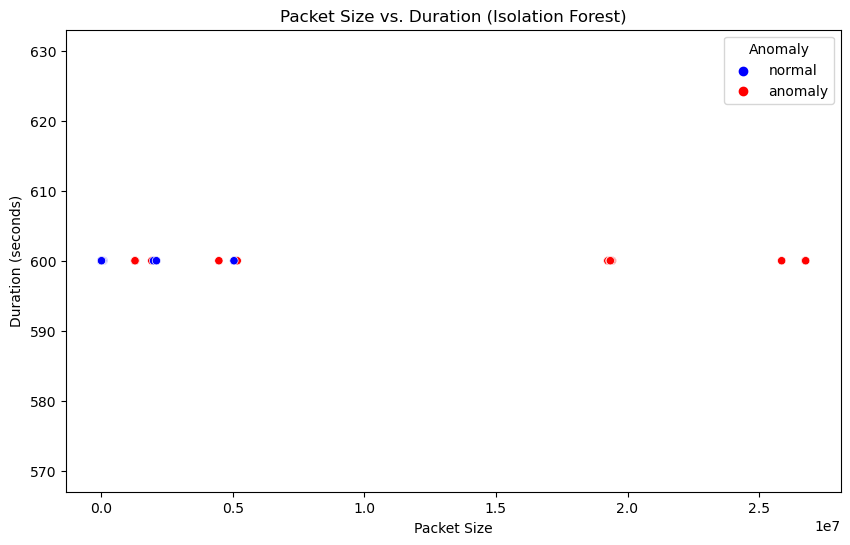

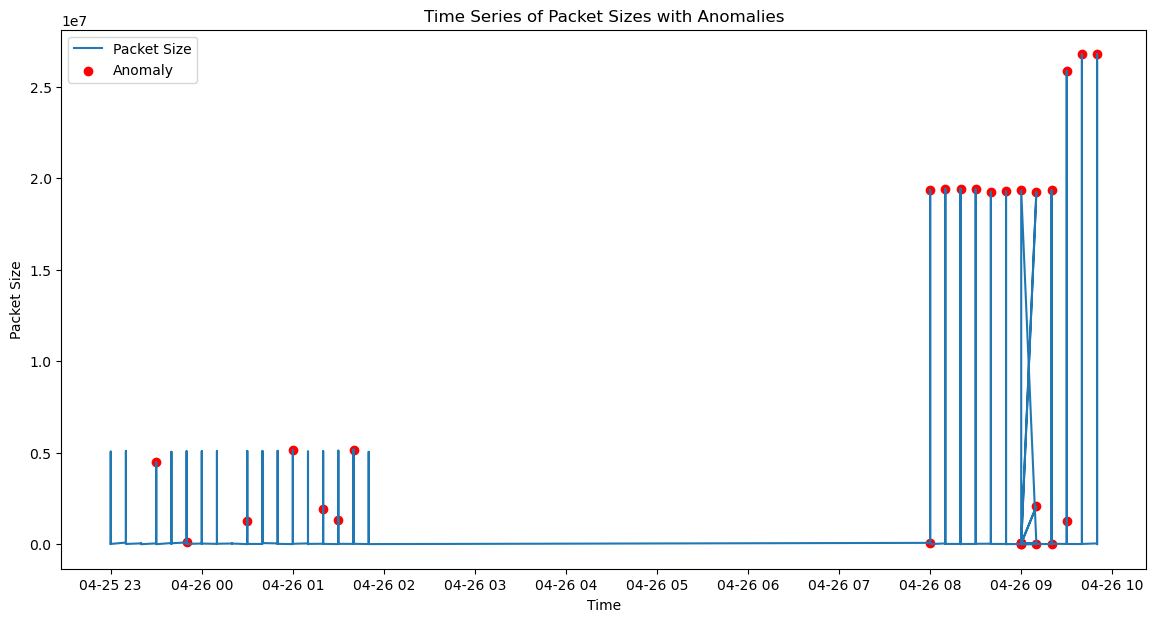

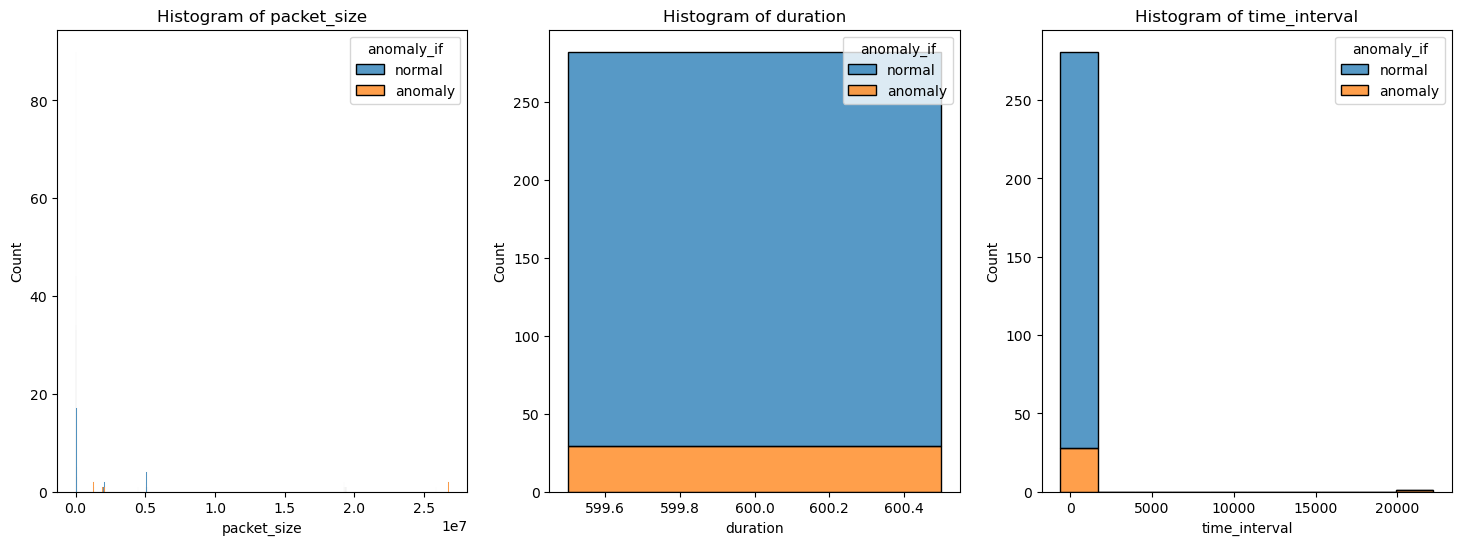

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='packet_size', y='duration', hue='anomaly_if', palette=['blue', 'red'])
plt.title('Packet Size vs. Duration (Isolation Forest)')
plt.xlabel('Packet Size')
plt.ylabel('Duration (seconds)')
plt.legend(title='Anomaly')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['packet_size'], label='Packet Size')
anomalies = df[df['anomaly_if'] == 'anomaly']
plt.scatter(anomalies['time'], anomalies['packet_size'], color='red', label='Anomaly')
plt.title('Time Series of Packet Sizes with Anomalies')
plt.xlabel('Time')
plt.ylabel('Packet Size')
plt.legend()
plt.show()

features = ['packet_size', 'duration', 'time_interval']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, hue='anomaly_if', multiple="stack", ax=axes[i])
    axes[i].set_title(f'Histogram of {feature}')
plt.show()
